* Подбор гиперпараметров
* Соблюдение границ пикселей
* Попробовать лосс только на 2 лейблах
* Оформить в архив
* Поощрять сетку оставаться (убрать плато)
* Грид серч у них
* На ночь все параметры
* Докер с гпу

In [1]:
from skimage import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request as urllib
from io import StringIO, BytesIO

from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim
%matplotlib inline

In [2]:
tf.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.'
)

tf.flags.DEFINE_string(
    'checkpoint_path', 'inception_v3.ckpt', 'Path to checkpoint for inception network.')

tf.flags.DEFINE_string(
    'input_dir', '', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_dir', '', 'Output directory with images.')

tf.flags.DEFINE_integer(
    'batch_size', 1, 'How many images process at one time.')

FLAGS = tf.flags.FLAGS

In [3]:
DATASET_FOLDER = 'dataset'
DEV_DATASET_CSV = os.path.join(DATASET_FOLDER, 'dev_dataset.csv')
IMAGES_FOLDER = os.path.join(DATASET_FOLDER, 'images')

In [4]:
df = pd.read_csv(DEV_DATASET_CSV)
df.head(5)

,ImageId,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
0,0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444...,0.000000,0.0,0.871838,1.000000,306,779,https://www.flickr.com/photos/gails_pictures/2...,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
1,f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183...,0.250000,0.0,1.000000,0.599758,884,378,https://www.flickr.com/photos/barty/28892033183,https://creativecommons.org/licenses/by/2.0/,Barry Badcock,https://www.flickr.com/people/barty/
2,4fc263d35a3ad3ee,https://c1.staticflickr.com/8/7378/27465801596...,0.333333,0.0,1.000000,1.000000,244,123,https://www.flickr.com/photos/foxcroftacademy/...,https://creativecommons.org/licenses/by/2.0/,Foxcroft Academy,https://www.flickr.com/people/foxcroftacademy/
3,cc13c2bc5cdd1f44,https://c1.staticflickr.com/9/8864/28546467522...,0.000000,0.0,0.500000,0.750000,560,741,https://www.flickr.com/photos/o_0/28546467522/,https://creativecommons.org/licenses/by/2.0/,Guilhem Vellut,https://www.flickr.com/people/o_0/
4,73a52afd2f818ed5,https://c1.staticflickr.com/6/5607/31066602702...,0.489195,0.0,1.000000,0.750000,439,696,https://www.flickr.com/photos/chemiebw/3106660...,https://creativecommons.org/licenses/by/2.0/,Chemie-Verb\303\244nde Baden-W\303\274rttemberg,https://www.flickr.com/people/chemiebw/


In [5]:
def make_filename(img_id):
    return img_id + '.png'

def make_filepath(img_id):
    return os.path.join(IMAGES_FOLDER, make_filename(img_id))

def open_img(img_id):
    filepath = make_filepath(img_id)
    return io.imread(filepath)

def get_image_and_target(num):
    line = df.ix[num]
    
    url = line['URL']
    img_id = line['ImageId']
    
    return open_img(img_id) / 255, line['TargetClass'], line['TrueLabel']

In [6]:
img, target, label = get_image_and_target(1)

In [7]:
target, label

(378, 884)

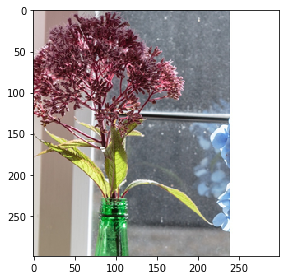

In [8]:
io.imshow(img)

In [9]:
target

378

In [51]:
class PushinMatyshin:
    def __init__(self):
        self.graph = tf.Graph()
        self.image_shape = (FLAGS.batch_size, 299, 299, 3)
        self.num_classes = 1001
        
        with self.graph.as_default():
            self.fake_image_subst = tf.Variable(
                np.zeros(self.image_shape, dtype=np.float32), name='fake_image_subst'
            )
            self.fake_image = (tf.tanh(self.fake_image_subst) + 1) / 2
        
            with slim.arg_scope(inception.inception_v3_arg_scope()):
                self.fake_logits, self.inception_end_points = inception.inception_v3(
                    self.fake_image, num_classes=self.num_classes, is_training=False,
                )
                
            self.softmaxed_fake = tf.nn.softmax(self.fake_logits)
            self.top_classes = tf.nn.top_k(self.softmaxed_fake, 3)
        
            self.real_image = tf.placeholder(tf.float32, self.image_shape, name='real_image')
            
            self.assign_fake_image_subs_by_real = self.fake_image_subst.assign(
                tf.atanh(2 * self.real_image - 1)
            )

            self.target_probs = tf.placeholder(
                tf.float32, [FLAGS.batch_size, self.num_classes], name='target_probs'
            )
            self.max_perturbation = tf.placeholder(tf.float32, (), name='max_perturbation')
            self.alpha = tf.placeholder(tf.float32, (), name='alpha')
            self.learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
            
            self.min_real_image = self.real_image - self.max_perturbation
            self.max_real_image = self.real_image + self.max_perturbation
            
            self.assign_fake_image_subs_by_clipped_fake = self.fake_image_subst.assign(
                tf.atanh(
                    2 * tf.clip_by_value(
                        self.fake_image, self.min_real_image, self.max_real_image
                    ) - 1
                )
            )

            self.main_loss = tf.losses.softmax_cross_entropy(
                self.target_probs,
                self.fake_logits,
                label_smoothing=0.1,
                weights=1.0
            )
            

            self.abs_img_diff = tf.abs(self.fake_image - self.real_image)
            self.clipped_img_diff = tf.where(
                    self.abs_img_diff > self.max_perturbation,
                    self.abs_img_diff, tf.zeros(self.image_shape)
                )
            self.clipped_diff_sum = tf.reduce_sum(self.clipped_img_diff)
            self.reg_loss = self.alpha * self.clipped_diff_sum

            self.loss = self.main_loss + self.reg_loss

            start_vars = set(x.name for x in tf.global_variables())
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            self.train = self.optimizer.minimize(self.loss, var_list=[self.fake_image_subst])
            
            end_vars = tf.global_variables()
            new_vars = [x for x in end_vars if x.name not in start_vars]
            self.init = tf.variables_initializer(var_list=[self.fake_image_subst] + new_vars)

            self.sess = tf.Session()
            saver = tf.train.Saver(slim.get_model_variables())
            saver.restore(self.sess, FLAGS.checkpoint_path)
    
    def inference(self, images, targets, max_perturbation=15, alpha=1, start_lr=0.1, end_lr=0.01, n=10):
        def clip_fake(real_image, max_perturbation):
            self.sess.run(
                [self.assign_fake_image_subs_by_clipped_fake], feed_dict={
                    self.max_perturbation: max_perturbation,
                    self.real_image: real_image,
                }
            )
        
        target_probs = np.zeros((len(targets), self.num_classes))
        max_perturbation /= 255
        
        learning_rate = start_lr
        
        for number, target in enumerate(targets):
            target_probs[number][target] = 1
        
        with self.graph.as_default():
            self.sess.run(self.init)
            result_images = self.sess.run(
                [self.assign_fake_image_subs_by_real], feed_dict={self.real_image: images}
            )

            for i in range(n):
                clip_fake(images, max_perturbation)
                result_images, loss, main_loss, reg_loss, softmaxed, fake_logits, top_classes, _ = self.sess.run(
                    [self.fake_image, self.loss, self.main_loss, self.reg_loss, self.softmaxed_fake, self.fake_logits, self.top_classes, self.train],
                    feed_dict={
                        self.real_image: images,
                        self.target_probs: target_probs,
                        self.max_perturbation: max_perturbation,
                        self.alpha: alpha,
                        self.learning_rate: learning_rate,
                    }
                )
                print(
                    'Step: {step} | Loss: {loss}, Mainloss: {main_loss}, Reg loss: {reg_loss} | Learning rate: {learning_rate}'.format(
                        step=i,
                        loss=loss,
                        main_loss=main_loss,
                        reg_loss=reg_loss,
                        learning_rate=learning_rate,
                    )
                )
                print(top_classes)
                learning_rate *= (end_lr / start_lr) ** (1/n)
                
            clip_fake(images, max_perturbation)
            return result_images, loss

In [52]:
pm = PushinMatyshin()

INFO:tensorflow:Restoring parameters from inception_v3.ckpt


In [68]:
img, target, label = get_image_and_target(15)
print(target, label)
result, loss = pm.inference([img], [target], max_perturbation=4, alpha=1, start_lr=0.05, end_lr=0.001, n=20)

925 542
Step: 0 | Loss: 15.125194549560547, Mainloss: 15.125194549560547, Reg loss: 0.0 | Learning rate: 0.05
TopKV2(values=array([[  9.94890332e-01,   3.56218475e-03,   7.04010890e-05]], dtype=float32), indices=array([[542, 543, 572]], dtype=int32))
Step: 1 | Loss: 259.6865539550781, Mainloss: 7.546279430389404, Reg loss: 252.14028930664062 | Learning rate: 0.04111700797134446
TopKV2(values=array([[ 0.10042835,  0.04327022,  0.01735419]], dtype=float32), indices=array([[572, 413, 542]], dtype=int32))
Step: 2 | Loss: 180.2705078125, Mainloss: 6.607548236846924, Reg loss: 173.6629638671875 | Learning rate: 0.03381216689031207
TopKV2(values=array([[ 0.02785805,  0.02460673,  0.01762107]], dtype=float32), indices=array([[572, 413, 542]], dtype=int32))
Step: 3 | Loss: 69.75945281982422, Mainloss: 6.135716915130615, Reg loss: 63.62373733520508 | Learning rate: 0.02780510271114781
TopKV2(values=array([[ 0.02068696,  0.01891226,  0.01806673]], dtype=float32), indices=array([[413, 542, 572]], 

In [69]:
img_b = (np.round(img * 255)).astype(np.int)
result_b = (np.round(result * 255)).astype(np.int)

In [70]:
np.max(img_b - result_b[0])

4

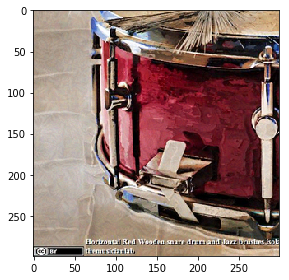

In [71]:
io.imshow(result[0])

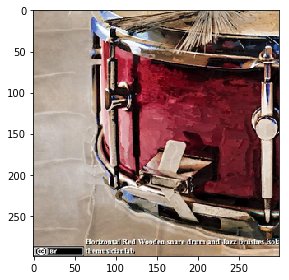

In [72]:
io.imshow(img)